# Quantum string matching using Grover's algorithm 

*Author*: Júlia Barberà, 26th May of 2022

This notebook presents a code to find a pattern in a given string using Grover's algorithm based on the article: 
"Quantum Pattern Matching" by P. Mateus and Y. Omar (eprint: [arXiv:quant-ph/0508237](https://arxiv.org/abs/quant-ph/0508237)).

For computational reasons, it simulates the solution for a string of length $N = 8$ and a pattern of length $M = 2$. 

The code is written using [Qibo](https://qibo.readthedocs.io/en/stable/) language and qibojit simulator as a default backend.

__Table of contents:__
1. [Quantum string matching](#quantum-string-matching)

2. [Example, string with N=8 and pattern N=2](#Example-string-with-N=8-and-pattern-N=2)

    1. [State initialization](#state-initialization)
    2. [Grover's algorithm](#grover's-algorithm)
    
        1. [Grover's Oracle](#grover's-oracle)
        2. [Diffusion operator](#diffusion-operator)  
    
3. [Extra functions](#extra-functions)

    1. [Binary to decimal](#binary-to-decimal)
    2. [Decimal to binary](#decimal-to-binary)
    
4. [Main code: Quantum string matching algorithm](#Main-code-quantum-string-matching-algorithm)

    1. [Quantum string matching](#quantum-string-matching)
    2. [Comparison with classical algorithms](#comparison-with-classical-algorithms)
    3. [Plots](#plots)
    

In [339]:
## Import all libraries that we will need
import math as m
import numpy as np
from qibo.models import Circuit
from qibo import gates
from qibo import callbacks
import matplotlib.pyplot as plt
import operator
import itertools

## Quantum string matching

The problem of finding occurrence of a pattern within another string can be solved using Grover's algorithm. 
Let's assume that we want to find where the pattern $|p\rangle$ of size M occurs within the string $|w\rangle$ of size N. In order to return the position $|i\rangle \in N$ we have to encode the position in a unit vector of a Hilbert subspace of dimension N: $|i\rangle = \{ |1\rangle, ...,|N\rangle\}$. 

Given the pattern p, if we consider that its length is $M = 2$, the second match will have to occur just after the first one. Therfore, the possible solutions of the problem has to represent a state like: $|i\rangle\otimes|i +1\rangle$ which the first state corresponds to the first index where the first pattern's character is found and the second state is the location of the second character of the given pattern within the given string.  

Consequently, the initial state for the index consists of a uniform superposition of all the possible solutions expressed like:

<br>

<center> $\hspace{30mm}|\psi_0\rangle =\frac{1}{\sqrt{N}}\sum^{N-M+1}_{i = 0}(|i\rangle \otimes |i +1\rangle\otimes...\otimes|i + M - 1 \rangle).               \hspace{20mm}(1) $ </center>

<br>

We will use qubits to represent all the quantum states which at the same time represent a decimal number (index where the pattern can be located), that can be transformed into binary. Each zero and one will be a qubit in that state. 

For example, the state $|i\rangle = |7\rangle$ will represent the position $7$ within the string $|w\rangle$. We can represent this state in binary like: $|111\rangle$  as the number of bits to write a binary number is determined by $n = ceil(\log_2{N})$ with $N$ the decimal number (in this case $n = 3$). Each number 1 of the state will be a qubit.That is why we need $s = \log_2{N - M}$ to represent each index $|i\rangle$. The total circuit will consist in a Hilbert space of dimension:

<br>

<center> $\hspace{30mm} d = N + M + 2 \cdot s,\hspace{30mm}(2)$ </center>

<br> 
If the pattern had more characters we should add $s$ qubits for each extra digit of the pattern. 

Once the initial state is prepared, the Grover's oracle $U_\sigma$ has to act over all the states. This oracle, that will be explained explicitly in the following sections, will mark (with a phase flip of $-1$) the position state that is the solution when there is a match between the pattern and the string value. More formally, we can express this oracle as: 

<br>

<center> $\hspace{30mm}U_\sigma(|i\rangle \otimes |i +1\rangle) = (-1)^{f_\sigma (i)}(|i\rangle \otimes |i +1\rangle),\hspace{30mm}(3)$ </center>

<br>
with, $ f_\sigma (i) = 1$ if the i-th character of $|w\rangle$ is $\sigma$ (in our case $\sigma ={0,1}$) and $ f_\sigma (i) = 0$ otherwise. After applying the oracle, the state which tell where the match has occurred will be flipped. 

The next step is to amplify the states that are solution using Grover's diffusion operator. This operator, as will be shown more in detail later, computes the average amplitude of all states and performs a reflection of each of their amplitude about the mean that has been calculated. We can express this operator in a general form as:
&nbsp;
<br>


<center> $\hspace{30mm}D_N = (2|\psi\rangle \langle \psi| - I ).\hspace{30mm}(4)$ </center> 

<br> 

When we measure, we will find that the state with the highest probability is the one that tells the location of the pattern within the string. 

The algorithm can be represented diagramatically as: 

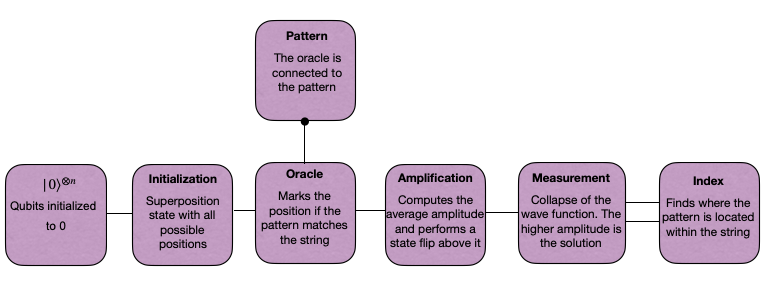

## Example, string with N=8 and pattern N=2

 In the following lines, we show how this algorithm works with an explicit example of an string N=8 and a pattern N=2. 

### State initialization

The initial state encodes possible positions where the given pattern can be located in the given string. It is important to keep in mind that Periodic Boundary Conditions are used for the initial state in order to reduce the number of qubits that are needed. For our case, this is reflected in the last state which the last state where the pattern can be found within the string is: $|7,0\rangle$ meaning that the first digit of the pattern is located at the last letter of the string and the second one at the beggining of the string. 
To distinguish between binary and numeric notation, we add XXX to the quantum states for the case of general numbers and nothing when we are dealing with qubit states, e.g. $|{3}\rangle = |11\rangle$.
Thus, to create this state for a case with $N = 8 $ and $M = 2 $ and represented by the following superposition: 

<br>

<center> $\psi =\frac{1}{2\sqrt{2}}(|0,1\rangle +|1,2\rangle +|2,3\rangle +|3,4\rangle +|4,5\rangle +|5,6\rangle +|6,7\rangle +|7,0\rangle ), $ </center>

<br>
we have to proceed as follows: 

- Firstly, initiate the circuit to $|0\rangle^{\otimes 6}$ using $s = log_2(N - M)$ qubits for each letter of the pattern, in our case 6.  
-  Apply hadamards to the first set of qubits (3 qubits) in order to have a superposition of all the index: $|0\rangle...|i\rangle$. This state will result in: 

<br>

<center> $|\psi\rangle =\frac{1}{2\sqrt{2}}(|000\rangle +|001\rangle +|010\rangle +|011\rangle +|100\rangle +|101\rangle +|110\rangle +|111\rangle ) \otimes |000\rangle$. </center>

<br>

- Entangle the the first set of qubits with the second one using CNOT (or CX) gates to obtain the state: $|\psi'\rangle =\frac{1}{\sqrt{N}}\sum_{i = 0}^7 (|i\rangle \otimes |i\rangle ). $  The CNOT gate acts on two qubits where the first one is the control and the second one the target. If the control is in the state $|1\rangle$ the second qubit is flipped. This gate is expressed by the following unitary matrix with respect to the basis $|00\rangle, |01\rangle, |10\rangle$ and $|11\rangle $: 

<br>

<center> $\hspace{30mm} CNOT = \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{bmatrix}\hspace{30mm}(5)$ </center> 
    
<br>

- Increment the index of the second set of qubits by 1, using MCX gates which act on M+2 qubits and where the first M+1 qubits act as controls and the last one is the target. If all the controls are in the state $|1\rangle$, the target qubit is flipped. For example, the CCX gate (also called TOFFOLI gate) is expressed by the matrix: 


<br>

<center> $\hspace{30mm}CCX = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\end{bmatrix}\hspace{20mm}(6)$ </center>
    
<br>
After appplying the logic quantum gates we obtain the initial state: 
<br>

<center> $\psi =\frac{1}{2\sqrt{2}}(|0,1\rangle +|1,2\rangle +|2,3\rangle +|3,4\rangle +|4,5\rangle +|5,6\rangle +|6,7\rangle +|7,0\rangle ). $ </center>

<br>
Notice that if the number of qubits $s$ is not an integer, we should expand the Hilbert space rounding up the number of qubits that are needed.

The circuit initialization diagram is shown below. 

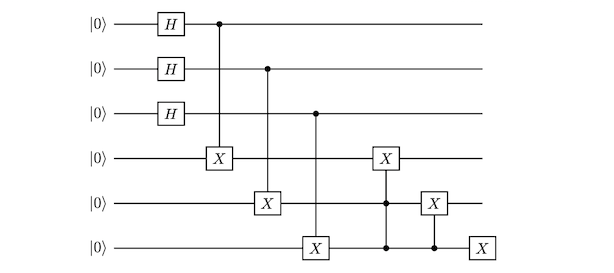

Now, we will proceed to show how to program de above initialization using Qibo. 

In [340]:
def initialize( NN, MM, ss, string_w, pattern_p):
    """
    Initialization of the quantum circuit.
    
    Parameters:
    N (integer): string length
    M (integer): pattern length
    s (integer): index qubits
    string_w (list): list of string integers
    pattern_p (list): list of string integers
    
    Returns
    Output (quantum circuit): String and pattern initialized and superposition of both index: |000>\otimes|001>...
    """
    
    # Adds X gate to string digits that are 1 
    for i in range(N): 
        if string_w[i] == 1: 
            c.add(gates.X(i))
            
    # Adds X gate to pattern digits that are 1
    for i in range(M): 
        if pattern_p[i] == 1: 
            c.add(gates.X(i + N))

  
    # Creates a superposition of the first index: |000> ...|111>
    for i in range(int(s/2)):
        c.add(gates.H(i + N + M))
        
    # Entanglement
    # Superposition of all possible index with both at the same state  
    for i in range(int(s/2)):
        c.add(gates.CNOT(i + N + M,i + int(s/2) + N + M))
    #Increments by 1 the second index (e.g. |000> to |001>) 
    for i in range(int(s/2)): 
        if i == (int(s/2)-1):
            c.add(gates.X(N + M + s - 1))
        else:
            c.add(gates.X(int(s/2) + i + N + M).controlled_by(*range(int(s/2) + i + N + M + 1, N + M + s)))

    return c

### Grover's algorithm

Grover's algorithm is used for unsorted data search problems and as a consequence we can express a quantum string search problem in a way that Grover's algorithm can be applied to find the solution. 
This algorithm is composed by an oracle which has the function to mark the solution state and a diffusion operator needed to amplify this state in order to measure it with the highest probability amond the other ones. 

#### Grover's diffusion operator: $U_s$

This operator, expressed like: $D_N = (2|\psi\rangle \langle \psi| - I )$, will be applied after the Oracle, and will perform an extra reflection of the state $U_w |s\rangle$. It will amplify the state we want to find by increasing its probability among the other ones. The Diffusion operator will have the following universal form : 

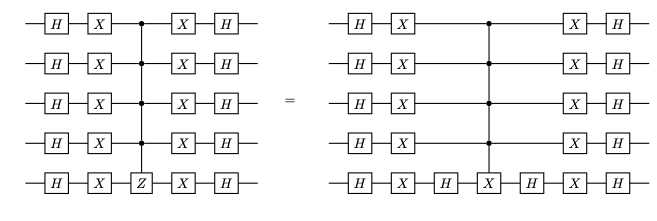

This operator computes the average of all states amplitudes and flips each state probability over this mean. 

In [341]:
def diffusion(NN, MM, ss): 
    """
    Amplification of the target using reflection operator.
    
    Parameters:
    N (integer): string length
    M (integer): pattern length
    s (integer): index qubits
    
    Returns
    Output (quantum circuit): States amplitudes reflected above the mean. 
    """
    
    #Superposition of the states
    c.add([gates.H(i) for i in range(N + M, N + M + s)])     
    c.add([gates.X(i) for i in range(N + M, N + M + s)])   
    c.add(gates.Z(N + M + s-1).controlled_by(*range(N + M, N + M + s-1)))
    c.add([gates.X(i) for i in range(N + M, N + M + s)])
    c.add([gates.H(i) for i in range(N + M, N + M + s)])
    
    return c

#### Grover's Oracle: $U_\sigma$

As our pattern is in binary, our alphabet will be $\Sigma = \{0,1\}$ and thus, the algorithm requires two oracles. 
They will be built up using X gates and MCZ gates which are represented by the following matrices: 
\begin{equation}
X =
\begin{bmatrix}
1 & 0 \\
0 & 1 
\end{bmatrix} 
\hspace{2mm} \text{and} \hspace{2mm} MCZ =
\begin{pmatrix}
1 & 0 & \cdots & 0\\
0 & 1 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & -1
\end{pmatrix}.
\end{equation}
If the pattern's symbol is in $|0\rangle$, X gates will be applied before and after the control to perform the transformation if the qubit is in $|0\rangle$.
For every symbol of the pattern the oracle acts as follows: 
1. Checks if the symbol matches every string character using controls. 
2. Applies X gates to every set of s qubits if their qubits are in $|0\rangle$, bringing them to the last entry of a MCZ matrix.
3. MCZ gate is implemented using as controls: the character qubit, the symbol qubit, and the first two qubits of $s$. The last qubit of the set $s$ is the target. 
4.  If all controls are in the same state, the index state is marked ($e^{i\pi}$ phase).

If we consider the first symbol, the first set of $s$ qubits will be used for the process. To check the second symbol, we need to use the second set of $s$ qubits and so on.

The circuit that has to be constructed for the first index if the symbol is at state $|1\rangle$ is presented below.

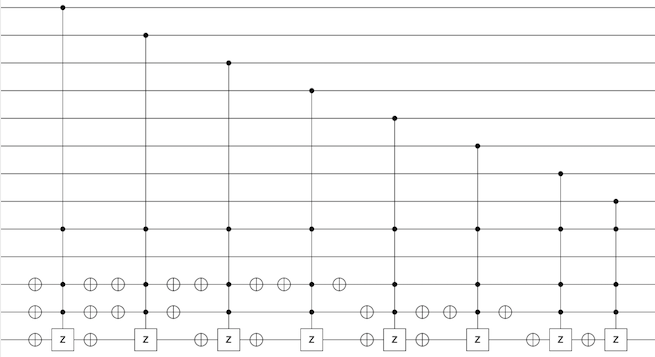
  
With some combinations of the string $|w\rangle$ and $|p\rangle$ we can have problems as there can be more than one state that has not been marked and has the same sign as the solution. As a consequence, we will apply the diffusion operator every time one of the oracles is applied to the states in order to see a higher amplification of the solution.

In [421]:
def oracle(NN,MM,ss,pp,equal):
    """
    Marks the index state if the string and pattern match.
    
    Parameters:
    N (integer): string length
    M (integer): pattern length
    s (integer): index qubits
    p (integer): pattern qubit used for comparison 
    equal (bool): if equal == True, the diffusion operator is called inside this function
    
    Returns
    Output (quantum circuit): states amplitudes reflected above the mean. 
    """
    
    #Controls ordered in function of the input list   
    controls = [3, 5, 6, 1, 2, 4, 0]
    
    #Creates a list of s length for the first index 
    inp_list = [*range(N + M, N + M + int(s/2))]
    combi = [ ]
    #Given a list of numbers, generates all the possible combinations without repetition of length r 
    for i in range(1, len(inp_list) + 1):
        combi.extend(list(itertools.combinations(inp_list, r = i)))
        
    #Comparing all string qubits with the pattern digit 
    for i in range(len(combi)+1):
        # If the state is in the last entry, no need to apply X gates 
        if  i == len(combi):
            # if the pattern qubit is 0, flips the controls  
            if p == 0: 
                c.add(gates.X(N - 1))
                c.add(gates.X(N))
            # Flips the state if the pattern matches the string
            c.add(gates.Z(N + M + 2).controlled_by(N-1, N, N + M, N + M + 1))
            if p == 0: 
                c.add(gates.X(N - 1))
                c.add(gates.X(N))
        else: 
            #Applies X gates to the qubits determined by the sublist of combi using the i-th control of controls
            # To bring them to the last entry of a MCZ gate
            c.add([gates.X(j) for j in list(combi[i])])
            if p == 0: 
                c.add(gates.X(controls[i]))
                c.add(gates.X(N))
            c.add(gates.Z(N + M + 2).controlled_by(controls[i], N, N + M, N + M + 1))
            if p == 0: 
                c.add(gates.X(controls[i]))
                c.add(gates.X(N))
            c.add([gates.X(j) for j in list(combi[i])])
            
    if equal is True: 
        diffusion(NN, MM, ss)
        
    #Creates a list of s length for the second index 
    inp_list = [*range(N + M + int(s/2), N + M + s)]
    combi = [ ]
    for i in range(1, len(inp_list) + 1):
        combi.extend(list(itertools.combinations(inp_list, r = i)))
        
    for i in range(len(combi)+1):
        if  i == len(combi): 
            if p == 0: 
                c.add(gates.X(N - 1))
                c.add(gates.X(N + 1))
            c.add(gates.Z(N + M + 5).controlled_by(N-1, N + 1, N + M + 3, N + M + 4))
            if p == 0: 
                c.add(gates.X(N - 1))
                c.add(gates.X(N + 1))
        else: 
            c.add([gates.X(j) for j in list(combi[i])])
            if p == 0: 
                c.add(gates.X(controls[i]))
                c.add(gates.X(N + 1))
            c.add(gates.Z(N + M + 5).controlled_by(controls[i] , N + 1, N + M + 3, N + M + 4))
            if p == 0: 
                c.add(gates.X(controls[i]))
                c.add(gates.X(N + 1))
            c.add([gates.X(j) for j in list(combi[i])])
            
    if equal is True: 
        diffusion(NN, MM, ss)
    
    return c

## Extra functions

Here we define some functions that will be used for solving this pattern matching problem. 

### Decimal to Binary 

This function takes as input the decimal number we need to convert to a binary number.  
First, it uses an integrated python function to convert the number into a binary string and then it removes first two digits "0b".

In [343]:
def bin_list(dec,nqubits):    
    """
    Creates a list of binary digits from a decimal number 
    
    Parameters:
    dec (integer): decimal number
    nqubits (integer): binary number size
    
    Returns
    Output (integer list): Binary digits list. 
    """
    #Converts a decimal number to binary of size nqubits
    binary = format(dec,'0{}b'.format(nqubits))
    
    #Creates a digits list
    return list(map(int, str(binary)))

### Binary to decimal 

There are two methods to convert a binary number into a decimal number and we will use the positional notation to convert them. The weight of the positions will be $2^0, 2^1, 2^2, 2^3,...$ so the first thing we need to do is count the number of digits (positions) the binary number has. Then, these weights will be multiplying the digit corresponding to its binary number (0 or 1). Finally, we will sum up everything. 

Let's assume our binary number is $10110$:


<br>

<center> decimal number $= 1 \cdot 2^4 + 0 \cdot 2^3 + 1 \cdot 2^2 + 1 \cdot 2^1 + 0 \cdot 2^0 = 22 $ </center>


<br>

The binary state will be the one we want to find, and we will use this function to transform the state into a decimal number to find the inverting matrix classically. 

In [344]:
def bin_to_dec(binary_number):
    """
    Transforms a binary number to decimal. 
    
    Parameters:
    binary_number (string): binary number
    
    Returns
    Output (integer): decimal number. 
    """
    
    decimal_number = 0 #Initialize the number 
    
    # Converts the binary to decimal using weights method
    for position, string_digit in enumerate(binary_number[::-1]):
        decimal_number += int(string_digit) * 2 ** position

    return decimal_number

## Main code: Grover's algorithm for quantum pattern matching

In this section we apply Grover's algorithm for the quantum string matching problem with $N = 8$, $M = 2$ and $s = 3$. This program will find where the pattern $|p\rangle$ is located within the string $|w\rangle$.

The steps to find the solution proceed as follows:
    
1. Asks which string do you want to use as the string $|w\rangle$.
2. Creates the initial entangled state: 
<br>

<center> $\psi =\frac{1}{2\sqrt{2}}(|0,1\rangle +|1,2\rangle +|2,3\rangle +|3,4\rangle +|4,5\rangle +|5,6\rangle +|6,7\rangle +|7,0\rangle ). $ </center>

<br>

3. Runs the whole Grover's algorithm (phase flip and amplification) two times in case the symbols of the pattern are different and one time if they are the same. Diffusion operator is called inside the function: oracle if the symbols are equal. 
4. Executes the circuit in order to find the result. 
5. Measures the state of the first three qubits which will correspond to the index of the string where the pattern can be found. 
6. Prints three columns corresponding to the state, the occurance of each state and their probability.

In [423]:
# Asks the string and the pattern to find within the string
string = input("Given string: " )
pattern = input("Pattern:  " )

# Converts the string and pattern to a list of their digits 
string_w  = [int(x) for x in str(string)]
pattern_p   = [int(x) for x in str(pattern)]

# Number of shots used for execution 
n_shots = int(input("Number of shots: " ))

# Number of qubits needed for string and pattern
N = len(string_w)
M = len(pattern_p)
# Number of qubits needed for indexes 
s = int(m.ceil(m.log2(N - M)))*M

# Creates the circuit using total number of qubits  
c = Circuit(N + M + s)
# Calls the function that initializes the circuit 
initialize( N, M, s, string_w, pattern_p)

# Calls the oracle and the diffusion operator which marks and amplifies the state
if pattern_p[0] == pattern_p[1]: 
        oracle(N,M,s,p,True)

else: 
    for p in pattern_p: 
        oracle(N,M,s,p,False)
        diffusion(N,M,s)
    
# Measures the first index qubits register which tells where the pattern is located 
c.add(gates.M(*range(N + M, N + M + int(s/2)), register_name="A"))
#Executes the circuit 
result = c(nshots = n_shots)
y = result.frequencies(binary=True, registers=True)

#Creates a table with states, their frequency and their probability
print('State', '\t\tOccurance','\tAmplitude')
for q_state in y['A']:
    print(q_state, '\t\t', y['A'][q_state],'\t\t',y['A'][q_state]/2000)

print()

#Prints where the pattern is located within the string computing the maximum probability
max_key = max(y['A'].items(), key = operator.itemgetter(1))[0]
print("The pattern has been found at index i =",bin_to_dec(max_key))

Given string: 11100000
Pattern:  10
Number of shots: 10000
State 		Occurance 	Amplitude
000 		 1332 		 0.666
001 		 1309 		 0.6545
010 		 1820 		 0.91
011 		 1015 		 0.5075
100 		 1040 		 0.52
101 		 998 		 0.499
110 		 1058 		 0.529
111 		 1428 		 0.714

The pattern has been found at index i = 2


# Plot

This plot shows probability vs all states available (created by 3 qubits). Notice that the one that has been measured with more frequency corresponds to the one we were searching for. We can see that the state with highest frequency is the index $|i\rangle$ where the pattern $|p\rangle$ is located within the string $|w\rangle$.

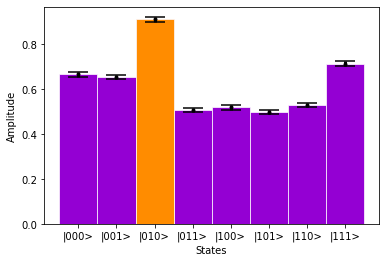

In [424]:
# List of x axis values 
x = list(y['A'])
xx = ["|"+el+">" for el in x] 
# Elevates coeficients to compute probability 
prob = [y['A'][el]/nshots for el in x] 
# Error given by Gaussian error
y_error = 1/m.sqrt(n_shots)

fig, ax = plt.subplots()
ax.bar(xx, prob, width=1, edgecolor="white",color = "darkviolet", linewidth=0.7)
ax.bar("|"+max_key+">", max(prob), width=1, edgecolor="white",color = "darkorange", linewidth=0.7)

# Sets the axis labels
ax.set(xlabel = 'States', ylabel = 'Amplitude')
# Sets the error bars
plt.errorbar(xx, prob,  yerr=y_error, fmt = 'o', ms=3, color='black', elinewidth = 3, capsize = 10, capthick = 1.5)
plt.savefig("StringMatching3.eps") 
plt.show()